# Building a Segmentation Model

## Data Prep 

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

# Ignores warnings
import warnings
warnings.simplefilter("ignore")

from IPython.display import Image
from ipywidgets import interact, fixed

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (6, 6)

In [57]:
df = pd.read_csv("SampleData.csv")

In [58]:
#Get rid of blank columns
df_col= df.columns[0:8]
df_col
df = df[df_col]
df.head()


#Renaming Variables, df changes to data
data = df.rename(columns={
   "ID Único":"UniqueID",
   "Data":"Date",
   "Unidade":"Facility",
   "Grupo EFR":"Payer",
   "Grupo Rúbrica":"SpecificService",
   "Tipo Rúbrica":"CategoryofService",
   "Sexo":"Sex",
   "Data de Nascimento":"BirthYear",
})

In [59]:
data["Age"]= 2019 - data["BirthYear"]

In [60]:
del data["BirthYear"]
del data["Date"]

## K-means 

In [61]:
numerical_data = data.select_dtypes(np.number)
categorical_data = data.select_dtypes([object, "category"])

In [62]:
for col in numerical_data.columns:
    numerical_data[col].fillna(numerical_data[col].mean(), inplace=True)

In [63]:
from sklearn.preprocessing import MinMaxScaler

numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data)
numerical_data_normalized = pd.DataFrame(
                    numerical_data_normalized,
                    columns=numerical_data.columns) 

In [64]:
from sklearn.preprocessing import MinMaxScaler

numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data)
numerical_data_normalized = pd.DataFrame(
                    numerical_data_normalized,
                    columns=numerical_data.columns) 

In [65]:
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    drop_first=True
)

In [66]:
data_processed = pd.concat([
                            numerical_data_normalized,
                            categorical_data_codified
                        ], axis=1
)

In [67]:
data_processed.shape

(44, 48)

In [68]:
data_processed.head()

,UniqueID,Age,Facility_CCB,Facility_HCIS,Facility_HCS,Payer_ADVANCECARE,Payer_MULTICARE,Payer_MÉDIS,Payer_OUTROS,Payer_PARTICULARES,...,CategoryofService_CONSULTA EXTERNA,CategoryofService_EQUIPA CIRURGICA,CategoryofService_EXAMES ESPECIAIS,CategoryofService_IMAGIOLOGIA,CategoryofService_INTERNAMENTO,CategoryofService_Internamento GDHS,CategoryofService_PATOLOGIA CLINICA,CategoryofService_SERVIÇOS E TÉCNICAS GERAIS,CategoryofService_URGÊNCIAS,Sex_M
0,0.000000,0.700,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.700,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.000000,0.700,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.000000,0.700,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.052632,0.575,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [69]:
from sklearn.cluster import KMeans

In [70]:
estimator_kmeans = KMeans(random_state=42, n_clusters=3)

estimator_kmeans.fit(data_processed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [77]:
clusters = estimator_kmeans.labels_

In [83]:
# estimator_kmeans.predict(data_processed)

In [80]:
centroids = estimator_kmeans.cluster_centers_

In [81]:
centroids.shape

(3, 48)

In [82]:
estimator_kmeans.inertia_

114.20718980308719

In [84]:
from sklearn.metrics import euclidean_distances

In [85]:
centroid_distances = euclidean_distances(centroids)

In [86]:
centroid_distances.shape

(3, 3)

In [88]:
data["cluster"] = clusters

In [90]:
data.head(10)

,UniqueID,Facility,Payer,SpecificService,CategoryofService,Sex,Age,cluster
0,1,HCIS,PARTICULARES,RX CONVENCIONAL,CONSULTA EXTERNA,F,58,2
1,1,CCA,PARTICULARES,URGÊNCIA GERAL,URGÊNCIAS,F,58,2
2,1,HCS,ADSE,GASTROENTEROLOGIA,IMAGIOLOGIA,F,58,1
3,1,HCIS,ADSE,RECOBRO,NaN,F,58,0
4,2,HCS,ADSE,NEURO-CIRURGIA,URGÊNCIAS,F,48,1
5,2,CCB,PARTICULARES,CARDIOLOGIA,EXAMES ESPECIAIS,F,48,2
6,3,HCIS,MULTICARE,SERVIÇOS E TÉCNICAS GERAIS,INTERNAMENTO,F,41,0
7,4,HCS,OUTROS,ECOGRAFIA,CONSULTA EXTERNA,M,51,1
8,5,HCIS,PARTICULARES,CIRURGIA TORÁCICA,BLOCOS,F,73,2
9,5,HCS,PARTICULARES,CARDIOLOGIA,IMAGIOLOGIA,F,73,2


In [94]:
def cluster_summary(cluster_id):
    cluster = data[clusters==cluster_id]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    cluster_summary["cluster_id"] = cluster_id
    return cluster_summary

In [96]:
cluster_summary(2)

{'Facility': 'CCB',
 'Payer': 'PARTICULARES',
 'SpecificService': 'CARDIOLOGIA',
 'CategoryofService': 'EXAMES ESPECIAIS',
 'Sex': 'F',
 'UniqueID': 7.9,
 'Age': 55.1,
 'cluster': 2.0,
 'cluster_id': 2}

In [98]:
# Distance between cluster 0 and 2 
centroid_distances[0,2]

1.395437925314091

In [99]:
def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [102]:
cluster_comparison(0,1,2)

cluster_id,0,1,2
Age,40.6667,47.3158,55.1
CategoryofService,CONSULTA EXTERNA,CONSULTA EXTERNA,EXAMES ESPECIAIS
Facility,HCIS,HCS,CCB
Payer,ADSE,ADSE,PARTICULARES
Sex,M,M,F
SpecificService,SERVIÇOS E TÉCNICAS GERAIS,NEURO-CIRURGIA,CARDIOLOGIA
UniqueID,11.8667,11.1579,7.9
cluster,0,1,2


### Clustering in Exploratory Data Analysis

In [103]:
def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

def graph_summary_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

In [104]:
cluster_results = kmeans_cluster(data_processed, 8)
cluster_summary = graph_summary_clustering(cluster_results);

In [105]:
cluster_results

,UniqueID,Age,Facility_CCB,Facility_HCIS,Facility_HCS,Payer_ADVANCECARE,Payer_MULTICARE,Payer_MÉDIS,Payer_OUTROS,Payer_PARTICULARES,...,CategoryofService_EQUIPA CIRURGICA,CategoryofService_EXAMES ESPECIAIS,CategoryofService_IMAGIOLOGIA,CategoryofService_INTERNAMENTO,CategoryofService_Internamento GDHS,CategoryofService_PATOLOGIA CLINICA,CategoryofService_SERVIÇOS E TÉCNICAS GERAIS,CategoryofService_URGÊNCIAS,Sex_M,Cluster
0,0.000000,0.7000,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
1,0.000000,0.7000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,5
2,0.000000,0.7000,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
3,0.000000,0.7000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0.052632,0.5750,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
5,0.052632,0.5750,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,6
6,0.105263,0.4875,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,2
7,0.157895,0.6125,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,7
8,0.210526,0.8875,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
9,0.210526,0.8875,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,3


In [108]:
matplotlib.rcParams['figure.figsize'] = [14, 14]

In [109]:
cluster_summary

,Age,CategoryofService_CIRURGIAS,CategoryofService_CONSULTA EXTERNA,CategoryofService_EQUIPA CIRURGICA,CategoryofService_EXAMES ESPECIAIS,CategoryofService_IMAGIOLOGIA,CategoryofService_INTERNAMENTO,CategoryofService_Internamento GDHS,CategoryofService_PATOLOGIA CLINICA,CategoryofService_SERVIÇOS E TÉCNICAS GERAIS,...,SpecificService_RESSONÂNCIA,SpecificService_REUMATOLOGIA,SpecificService_RX CONVENCIONAL,SpecificService_SERVIÇOS E TÉCNICAS GERAIS,SpecificService_SERVIÇOS ESPECIAIS CARDIOLOGIA,SpecificService_SERVIÇOS ESPECIAIS GASTROENTEROLOGIA,SpecificService_SERVIÇOS ESPECIAIS OFTALMOLOGIA,SpecificService_SISTEMA MUSCULO ESQUELÉTICO,SpecificService_URGÊNCIA GERAL,UniqueID
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.511111,0.000000,0.666667,0.0,0.00,0.000000,0.0,0.00,0.0,0.111111,...,0.00,0.0,0.111111,0.222222,0.0,0.000000,0.000000,0.111111,0.111111,0.771930
1,0.515625,0.000000,0.000000,0.0,0.75,0.000000,0.0,0.25,0.0,0.000000,...,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.789474
2,0.618750,0.000000,0.000000,0.1,0.10,0.100000,0.1,0.00,0.2,0.000000,...,0.10,0.1,0.000000,0.100000,0.0,0.000000,0.000000,0.000000,0.000000,0.336842
3,0.691071,0.000000,0.000000,0.0,0.00,0.714286,0.0,0.00,0.0,0.142857,...,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.428571
4,0.446875,0.000000,1.000000,0.0,0.00,0.000000,0.0,0.00,0.0,0.000000,...,0.25,0.0,0.250000,0.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.407895
5,0.600000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.00,0.0,0.000000,...,0.00,0.0,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.500000,0.421053
6,0.556250,0.000000,0.000000,0.0,1.00,0.000000,0.0,0.00,0.0,0.000000,...,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.263158
7,0.477083,0.166667,0.833333,0.0,0.00,0.000000,0.0,0.00,0.0,0.000000,...,0.00,0.0,0.000000,0.000000,0.0,0.166667,0.166667,0.000000,0.166667,0.482456


In [110]:
from scipy.spatial.distance import cdist

In [112]:
total_variance = cdist(
    XA=data_processed, 
    XB=np.array([data_processed.mean()])
)

In [113]:
total_variance_sum = total_variance.sum()

In [114]:
total_variance_sum

78.92174981179123

In [123]:
#functions to calculate the Within-Cluster sum of squares (WSS)
def cluster_variance(cluster_id, cluster_centroid, cluster_labels):
    cluster_elements = data_processed[cluster_labels==cluster_id]
    return cdist(XA=cluster_elements, XB=np.array([cluster_centroid])).sum()


#explained variance (defined as the reduction of variance compared to the total variance, which would be the variance where k=1).
def variance_measure(estimator_kmeans, total_variance):
    clusters_labels = estimator_kmeans.labels_
    wss = 0
    for i, cluster_id in enumerate(np.unique(clusters_labels)):
        cluster_centroid = estimator_kmeans.cluster_centers_[i]
        wss += cluster_variance(cluster_id, cluster_centroid, clusters_labels)
    return (total_variance-wss) / total_variance

In [124]:
# Function that returns the inertia.
def inertia_measure(estimator_kmeans):
    return estimator_kmeans.inertia_

In [125]:
# Create a function that evaluates the intertia and percentage variance explained for a value of K
def evaluate_k_kmeans(k, scoring, **kwargs):
    scoring_measure = None
    if scoring=="inertia":
        scoring_measure = inertia_measure
    elif scoring=="variance":
        scoring_measure = variance_measure
        
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(data_processed)
    return scoring_measure(estimator_kmeans, **kwargs)

In [132]:
results_k = {}
range_k = [1, 3, 5, 6, 7, 8, 9, 10]
for k in range_k:
    results_k[k] = (
        evaluate_k_kmeans(k, "inertia"), 
        evaluate_k_kmeans(k, "variance", total_variance=total_variance_sum), 
    )

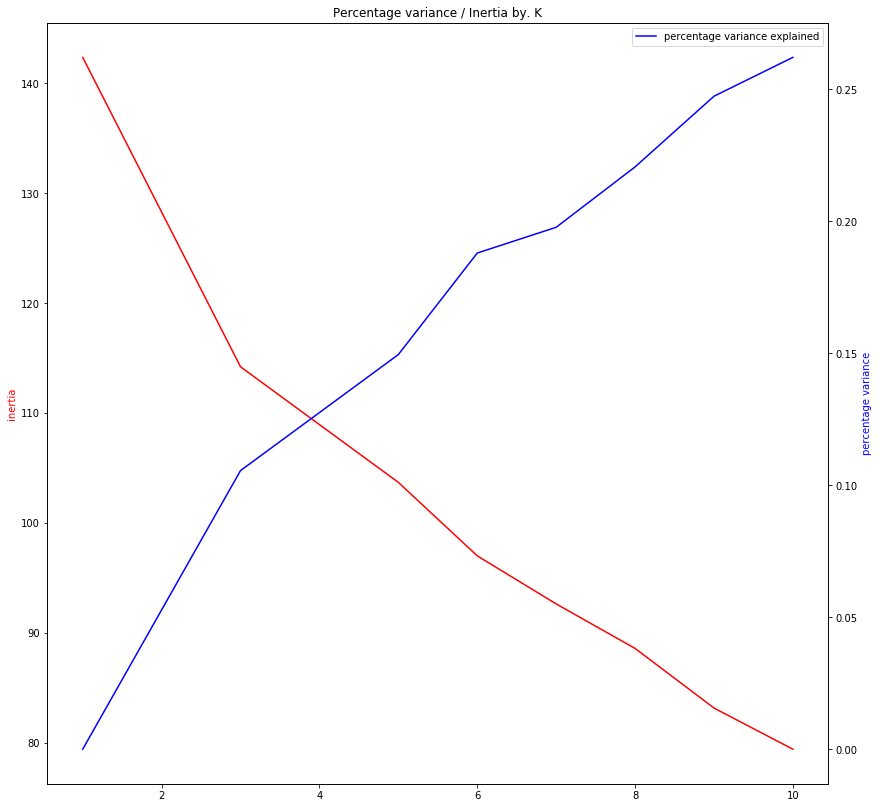

In [133]:
fig, ax1 = plt.subplots()

ax1.plot(
    [c[0] for c in results_k.items()],
    [c[1][0] for c in results_k.items()], label="inertia", color="red")
ax1.set_ylabel('inertia', color="red")


ax2 = ax1.twinx()
ax2.plot(
    [c[0] for c in results_k.items()],
    [c[1][1] for c in results_k.items()], label="percentage variance explained", color="blue")
ax2.set_ylabel('percentage variance', color='blue')

plt.xlabel("K")
plt.legend()
plt.title("Percentage variance / Inertia by. K");